# Titanic Data Exploration and Model

## Introduction
Tis is the notebook that I used to get a top 10% score on "Titanic: Machine Learning from Disaster", at time of publication.

![Top 8%](https://i.imgur.com/N1PmqdL.png)

## Initial Library Imports

In [1]:
# This code is an adaptation from Cody McCormack
# I gave an initial bias to 0.55 rather than 0.5

import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv


## EDA

In [2]:
titanic_data = pd.read_csv('../input/titanic/train.csv')
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


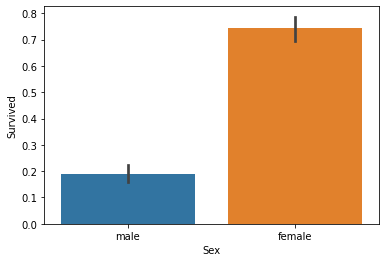

In [3]:
sns.barplot(x='Sex', y='Survived', data=titanic_data)


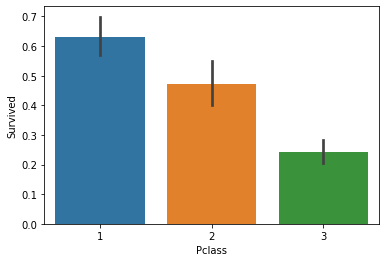

In [4]:
sns.barplot(x='Pclass', y='Survived', data=titanic_data)


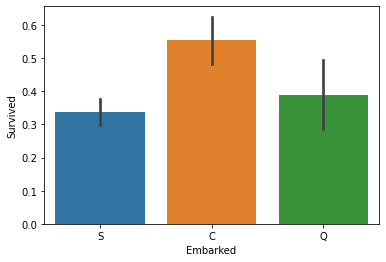

In [5]:
sns.barplot(x='Embarked', y='Survived', data=titanic_data)

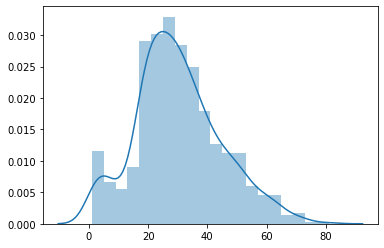

In [6]:
age_survived = titanic_data['Age'] + titanic_data['Survived']
sns.distplot(age_survived)

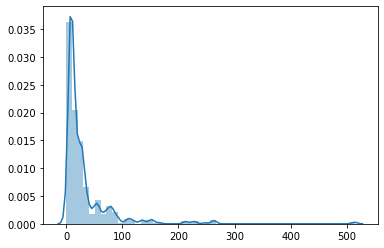

In [7]:
fare_survived = titanic_data['Fare'] + titanic_data['Survived']
sns.distplot(fare_survived)

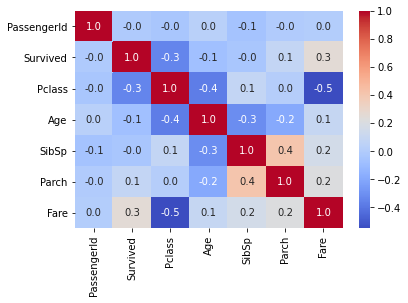

In [8]:
g = sns.heatmap(titanic_data.corr(),annot=True, fmt = ".1f", cmap = "coolwarm")

## Model Creation

In [9]:
features = [x for x in titanic_data.columns if x not in ['Survived']]
X = titanic_data[features]
y = titanic_data['Survived']

In [10]:
X_initial = X.copy()
X_initial['family_size'] = X_initial['SibSp'] + X_initial['Parch'] + 1
X_initial['embarked_class'] = X_initial['Embarked'] + '_' + X_initial['Pclass'].astype(str)
X_initial = X_initial.drop(columns=['Name', 'Ticket'], axis=1)
numerical_cols = [cname for cname in X_initial.columns if 
                X_initial[cname].dtype in ['int64', 'float64']]

categorical_cols = [cname for cname in X_initial.columns if
                    X_initial[cname].nunique() < 18 and 
                    X_initial[cname].dtype in ['object', 'bool']]

numerical_transformer = SimpleImputer(strategy='constant')

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

#Couldn't change the Imputer as male vs female is a binary choice. Perhaps some kind of encoder specifically for gender?

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
])

model = XGBClassifier(base_score=0.55, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=1.5, gpu_id=None,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.02, max_delta_step=0, max_depth=9,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=400, n_jobs=1, nthread=1, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1.0, tree_method='exact', validate_parameters=1,
              verbosity=None)
#Things tried:
# A higher base_score increase likelihood 0.5->0.75
#The different importance types don't change much
# gbtree is the best booster
#Learning rate changes led nowhere
#Max_delta changes step led nowhere
#A higher max_depth led to better results 6->9, Do odd values work in tangent? Even values seemed to stay the same
# n_estimator changes went lower or no change
# random_state changes did nothing
# Tree_method choice 'exact' is valid for this small data set



clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])

X_train, X_valid, y_train, y_valid = train_test_split(X_initial, y, random_state=0)

clf.fit(X_train, y_train)
preds = clf.predict(X_valid)
print('Accuracy Score:', accuracy_score(y_valid, preds))
#Accuracy Score: 0.8340807174887892
#My best score:  0.8475336322869955

Accuracy Score: 0.8430493273542601


In [11]:
X_test = pd.read_csv('../input/titanic/test.csv')
X_test['family_size'] = X_test['SibSp'] + X_test['Parch'] + 1
X_test['embarked_class'] = X_initial['Embarked'] + '_' + X_test['Pclass'].astype(str)
X_test = X_test.drop(columns=['Name', 'Ticket'], axis=1)
preds = clf.predict(X_test)
output = pd.DataFrame({'PassengerId': X_test.PassengerId,
                       'Survived': preds})
output.to_csv('submission_N2.csv', index=False)